# Análise de Risco de Crédito - NuBank

Risco de crédito está associado à possibilidade de um cliente não cumprir com as obrigações contratuais, como hipotecas, dívidas de cartão de crédito e outros tipos de empréstimos.

Minimizar o risco de inadimplência é uma grande preocupação para instituições financeiras. Por esse motivo, bancos comerciais e de investimento, fundos de capital de risco, empresas de gestão de ativos e seguradoras, para citar alguns, estão cada vez mais contando com a tecnologia para prever quais clientes são mais propensos a não honrar com as suas dívidas.

Modelos de Machine Learning têm ajudado essas empresas a melhorar a precisão de suas análises de risco de crédito, fornecendo um método científico para identificar devedores em potencial com antecedência.

Neste projeto, construiremos um modelo para prever o risco de inadimplência do cliente para o Nubank, uma das maiores e importantes Fintechs brasileira.

## Modelagem 

### Objetivo

- Prever o risco de inadimplência de clientes usando modelos de aprendizado de máquina, incluindo Regressão Logística,XGBoost, LightGBM e CatBoost.

- Problema: Identificar a possibilidade de clientes não cumprirem obrigações contratuais, como empréstimos e pagamentos.

### Importação das Bibliotecas

In [30]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
import time
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário


import warnings


# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:20,.2f}'.format

# Funções


## Funcão para detectar Outliers e Remoção

In [31]:
def detectar_e_substituir_outliers(df):
    """
    Função que detecta e substitui outliers por NaN com base no método IQR.

    """
    for column in df.select_dtypes(include=[np.number]).columns:  # Process only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with NaN
        df[column] = df[column].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    print("Os valores discrepantes foram substituídos por NaN.")
    return df

### Importação do Dataset

In [32]:
df = pd.read_csv('data/acquisition_train.csv')

### Visualização dos Dados

In [33]:
df.head(2)

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.00,101.80,0.26,108.43,0.40,"25,033.92",...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,"57,849.00",BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.00,97.06,0.94,92.00,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,"4,902.00",BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN


### Infos dos Dados

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

- Temos dados ausentes

### Exclusão das Variáveis não significativas

- Seguindo como base os processos feitos na Análise Exploratória de Dados - EDA, vamos excluir logo de início as variáveis não relevantes para o projeto, seguido da variável **Shipping State** por não agregar até o momento nenhuma significância para o projeto. Não vejo valor na distribuição dos estados com relação as outras variáveis.

In [35]:
# cópia do dataframe
df2 = df.copy()

In [36]:
exclude_columns = ["ids", "score_1", "score_2", "score_4", "score_5", "score_6","reason", "facebook_profile", "state", "zip", "channel", "job_name", "real_state",
                    "email", "external_data_provider_first_name", "external_data_provider_email_seen_before","lat_lon", "marketing_channel",
                    "application_time_applied", "profile_phone_number", "application_time_in_funnel","shipping_zip_code", "external_data_provider_fraud_score",
                    "profile_tags", "user_agent", "shipping_state","target_fraud"]

df2.drop(labels = exclude_columns, axis=1, inplace=True)

### Alteração variável Target Default para Num

In [37]:
df2['target_default'] = df2['target_default'].map({False: 0, True: 1})

### Alteração da Variável credit_limit com valor 0

- A variável **credit_limit** possui um valor mínimo de 0.000000, isso não existe em instituições financeiras, é obrigatório liberar um valor X de crédito para o cliente. Portanto, este valor será substituído por NaN.

In [38]:
df2['credit_limit'] = df2['credit_limit'].apply(lambda x: np.nan if x == 0 else x)

### Alteração da Variável reported_income com Valor Inf

- A variável **reported_income** possui um valor máximo descrito como inf(infinito), nesse caso, vamos alterar para o tipo NaN.

In [39]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

### Feature Engineering

Seguindo o que foi feito com as "Perguntas de Negócio utilizando o Score 3" na Análise Exploratória no eda.ipynb, que é o Score mais robusto para o projeto, vamos criar uma nova variável chamada Scores, onde vamos dividir os valores seguindo com base na descrição do Score anteriormente:

O score brasileiro é geralmente dividido em faixas:

- Baixo (0-300): Alto risco de inadimplência.
- Médio (301-700): Risco moderado.
- Alto (701-1000): Baixo risco de inadimplência.

Então vamos ter uma variável chamada de "score" que será dividida com os valores dessa forma e vamos excluir as outras colunas de score para essa nova análise.

In [40]:
def scores(score):
    if score <= 300:
        return 'baixo'
    elif score >= 301 and score <= 700:
        return 'medio'
    else:
        return 'alto'
    
df2['score'] = df2['score_3'].apply(scores)

- Exclusão da variável score_3

In [41]:
df2.drop(columns=['score_3'], axis = 1, inplace = True)	

## Modelos Logíticos Binários

Respostas binárias são comumente estudadas em muitos campos. Exemplos incluem a presença ou ausência de uma doença específica, morte durante uma cirurgia ou a decisão de um consumidor em comprar um produto. Frequentemente, deseja-se estudar como um conjunto de variáveis preditoras **X** está relacionada a uma variável de resposta dicotômica **Y**. Os preditores podem descrever quantidades como a atribuição de tratamento, dosagem, fatores de risco e tempo de calendário.

Por conveniência, definimos a resposta como **Y** **=** **0** ou **1**, com **Y** **=** **1** denotando a ocorrência do evento de interesse. Frequentemente, um resultado dicotômico pode ser estudado calculando certas proporções, por exemplo, a proporção de mortes entre mulheres e a proporção entre homens. No entanto, em muitas situações, há vários descritores, ou um ou mais descritores são contínuos. Sem um modelo estatístico, estudar padrões como a relação entre idade e ocorrência de uma doença, por exemplo, exigiria a criação de grupos etários arbitrários para permitir a estimativa da prevalência da doença em função da idade.

Portanto, diferentemente da tradicional técnica de **regressão linear**, que é estimada por meio de métodos de **mínimos quadrados**, em que a variável dependente apresenta-se de forma quantitativa e devem ser obedecidos alguns pressupostos, as técnicas de **regressão logística** são utilizadas quando o fenômeno a ser estudado apresenta-se de forma qualitativa e, portanto, é representado por uma ou mais variáveis **dummy**, dependendo da quantidade de possibilidades de resposta (categorias) dessa variável dependente.

Em **Machine Learning**, é uma técnica **supervisionada** utilizada para explicar ou predizer a probabilidade de ocorrência de determinado evento em função de uma ou mais variáveis explicativas, em que a variável dependente é binária, com resultados interpretados em termos de probabilidades, e as variáveis preditoras **X** são métricas ou não métricas.

### O MODELO DE REGRESSÃO LOGÍSTICA BINÁRIA

O modelo de regressão logística binária é uma técnica estatística usada para prever a probabilidade de ocorrência de um evento que tem dois resultados possíveis (binário). Ele é amplamente utilizado em problemas de classificação, onde a variável dependente (resposta) é categórica e assume apenas dois valores, como 0 ou 1, "Sim" ou "Não", "Sucesso" ou "Fracasso".

### Conceito Básico

A regressão logística modela a probabilidade de um evento ocorrer usando uma função logística (também chamada de sigmoide). A função **sigmoide** transforma qualquer valor real em um valor entre 0 e 1, que pode ser interpretado como uma probabilidade.

### Função Sigmoide

A função sigmoide é dada por:

$$P(Y = 1 \mid X) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n\right)}}$$

Onde: 

- $P(Y = 1 \mid X)$ é a probabilidade de a variável dependente **Y** ser igual a 1, dado o conjunto de variáveis independentes **X**.

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.

- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).

- $e$ é a base do logaritmo natural (aproximadamente 2.71828).





### Função de Ligação (Logit)

A regressão logística usa a função de ligação logit para modelar a relação entre as variáveis independentes e a probabilidade de ocorrência do evento. O logit é o logaritmo natural da razão de chances (odds ratio):

$$\text{logit}(P(Y = 1 \mid X)) = \ln\left(\frac{1 - P(Y = 1 \mid X)}{P(Y = 1 \mid X)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$


### Estimação dos Coeficientes

Os coeficientes $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são estimados usando o método de máxima verossimilhança (Maximum Likelihood Estimation - MLE). O objetivo é encontrar os valores dos coeficientes que maximizam a função de verossimilhança, que é a probabilidade de observar os dados dados os parâmetros do modelo.

### Interpretação dos Coeficientes

- Coeficiente $\beta_0$: É o intercepto do modelo. Representa o logaritmo da razão de chances quando todas as variáveis independentes são iguais a zero.

- Coeficientes $\beta_1, \beta_2, \dots, \beta_n$: Representam a mudança no logaritmo da razão de chances para um aumento unitário na variável independente correspondente, mantendo todas as outras variáveis constantes.

### Odds

Na regressão logística, o conceito de chance (ou odds, em inglês) é fundamental para entender como o modelo estima a probabilidade de um evento ocorrer. Vamos explorar o que significa "chance" e como ela se relaciona com a regressão logística.

1. O que é Chance?

A chance é uma medida que compara a probabilidade de um evento ocorrer com a probabilidade de ele não ocorrer. Em outras palavras, é a razão entre a probabilidade de sucesso $\left(P(Y = 1)\right)$ e a probabilidade de fracasso $\left(P(Y = 0)\right)$
.

A fórmula da chance é: 

$$\text{Chance} = \frac{P(Y = 1)}{1 - P(Y = 1)}$$

Onde: 

- ${P(Y = 1)}$ é a probabilidade de o evento ocorrer.
- ${1 - P(Y = 1)}$ é a probabilidade de o evento não ocorrer.



2. Exemplo de Chance

Suponha que a probabilidade de um evento ocorrer seja $(P(Y = 1) = 0.75$. Então:

- A probabilidade de o evento não ocorrer é $1 - 0,75 = 0,25$.
- A chance de o evento ocorrer é: $$\text{Chance} = \frac{0,75}{0,25} = 3$$

Isso significa que a chance de o evento ocorrer é **3 para 1** (ou seja, o evento é 3 vezes mais provável de ocorrer do que não ocorrer).

3. Chance e Regressão Logística

Na regressão logística, o modelo estima a chance de um evento ocorrer com base nas variáveis independentes $(X)$. A relação entre as variáveis independentes e a chance é modelada pela função logística.

A regressão logística usa o **logaritmo da chance** (também chamado de logit) como variável dependente. A fórmula do logit é:

$$\text{logit}(P(Y = 1)) = \ln\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$

Onde:

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.
- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).


In [42]:
df2.head()

,target_default,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score
0,0.00,0.40,"25,033.92",36.00,NaN,"65,014.12",NaN,0.00,0.00,18.00,18.00,NaN,2,0.00,"57,849.00",medio
1,0.00,0.24,NaN,NaN,"39,726.00","100,018.91",50.00,0.00,0.00,14.00,14.00,0.00,1,0.00,"4,902.00",medio
2,1.00,0.29,"7,207.92",36.00,NaN,"65,023.65",NaN,0.00,0.00,10.00,NaN,NaN,2,NaN,"163,679.00",medio
3,0.00,0.32,NaN,NaN,"54,591.00","68,830.01",NaN,1.00,0.00,19.00,19.00,NaN,3,NaN,"1,086.00",medio
4,0.00,0.18,NaN,NaN,NaN,"60,011.29",NaN,0.00,0.00,11.00,NaN,0.00,2,1.00,"198,618.00",medio


### Divisão dos dados em treino e teste

- Antes de iniciar as transformações e pré-processamentos dos dados, é necessário dividir o dataset em treino e teste, mas porque?
    - Porque precisamos evitar o "Data Leakage". Data Leakage ocorre quando informações do conjunto de dados de teste ou validação vazam para o conjunto de treinamento durante o pré-processamento ou modelagem, ou quando informaçõpes do target vazam para as features. Nessas situações, o que vai acontecer é que você vai ver um modelo muito bom, mas isso será ilusório, pois o seu modelo "roubou" para ter o resultado bom.

- Referências sobre Data Leakage: 
    - https://www.linkedin.com/company/universidade-dos-dados/posts/?feedView=all
    - https://www.casadocodigo.com.br/products/livro-escd
    - https://estatsite.com.br/2020/12/12/data-leakage-o-erro-que-ate-os-grandes-cometem/


In [43]:
# Dividindo os dados primeiro

X = df2.drop(columns=['target_default'], axis = 1)	
y = df2['target_default'].copy()                                                                                                                                                                                                                                                                                    

### Aplicando o One Hot Encoding antes do Train Test Split

In [44]:
# Aplicando o One Hot Encoding

encoder = OneHotEncoder(drop='first', sparse_output=False) 

X_encoded = encoder.fit_transform(X[['score']])

encoded_columns = encoder.get_feature_names_out(['score'])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)

X = pd.concat([X.drop(columns=['score']), X_encoded_df], axis=1)

### Remoção dos Outliers

- Aqui vamos remover os Outliers para um primeiro CRISP-DM, então o dataset não terá os valores discrepantes para criação dos modelos. 

In [45]:
X = detectar_e_substituir_outliers(X)

Os valores discrepantes foram substituídos por NaN.


### Boxplot Dataframe Atualizado

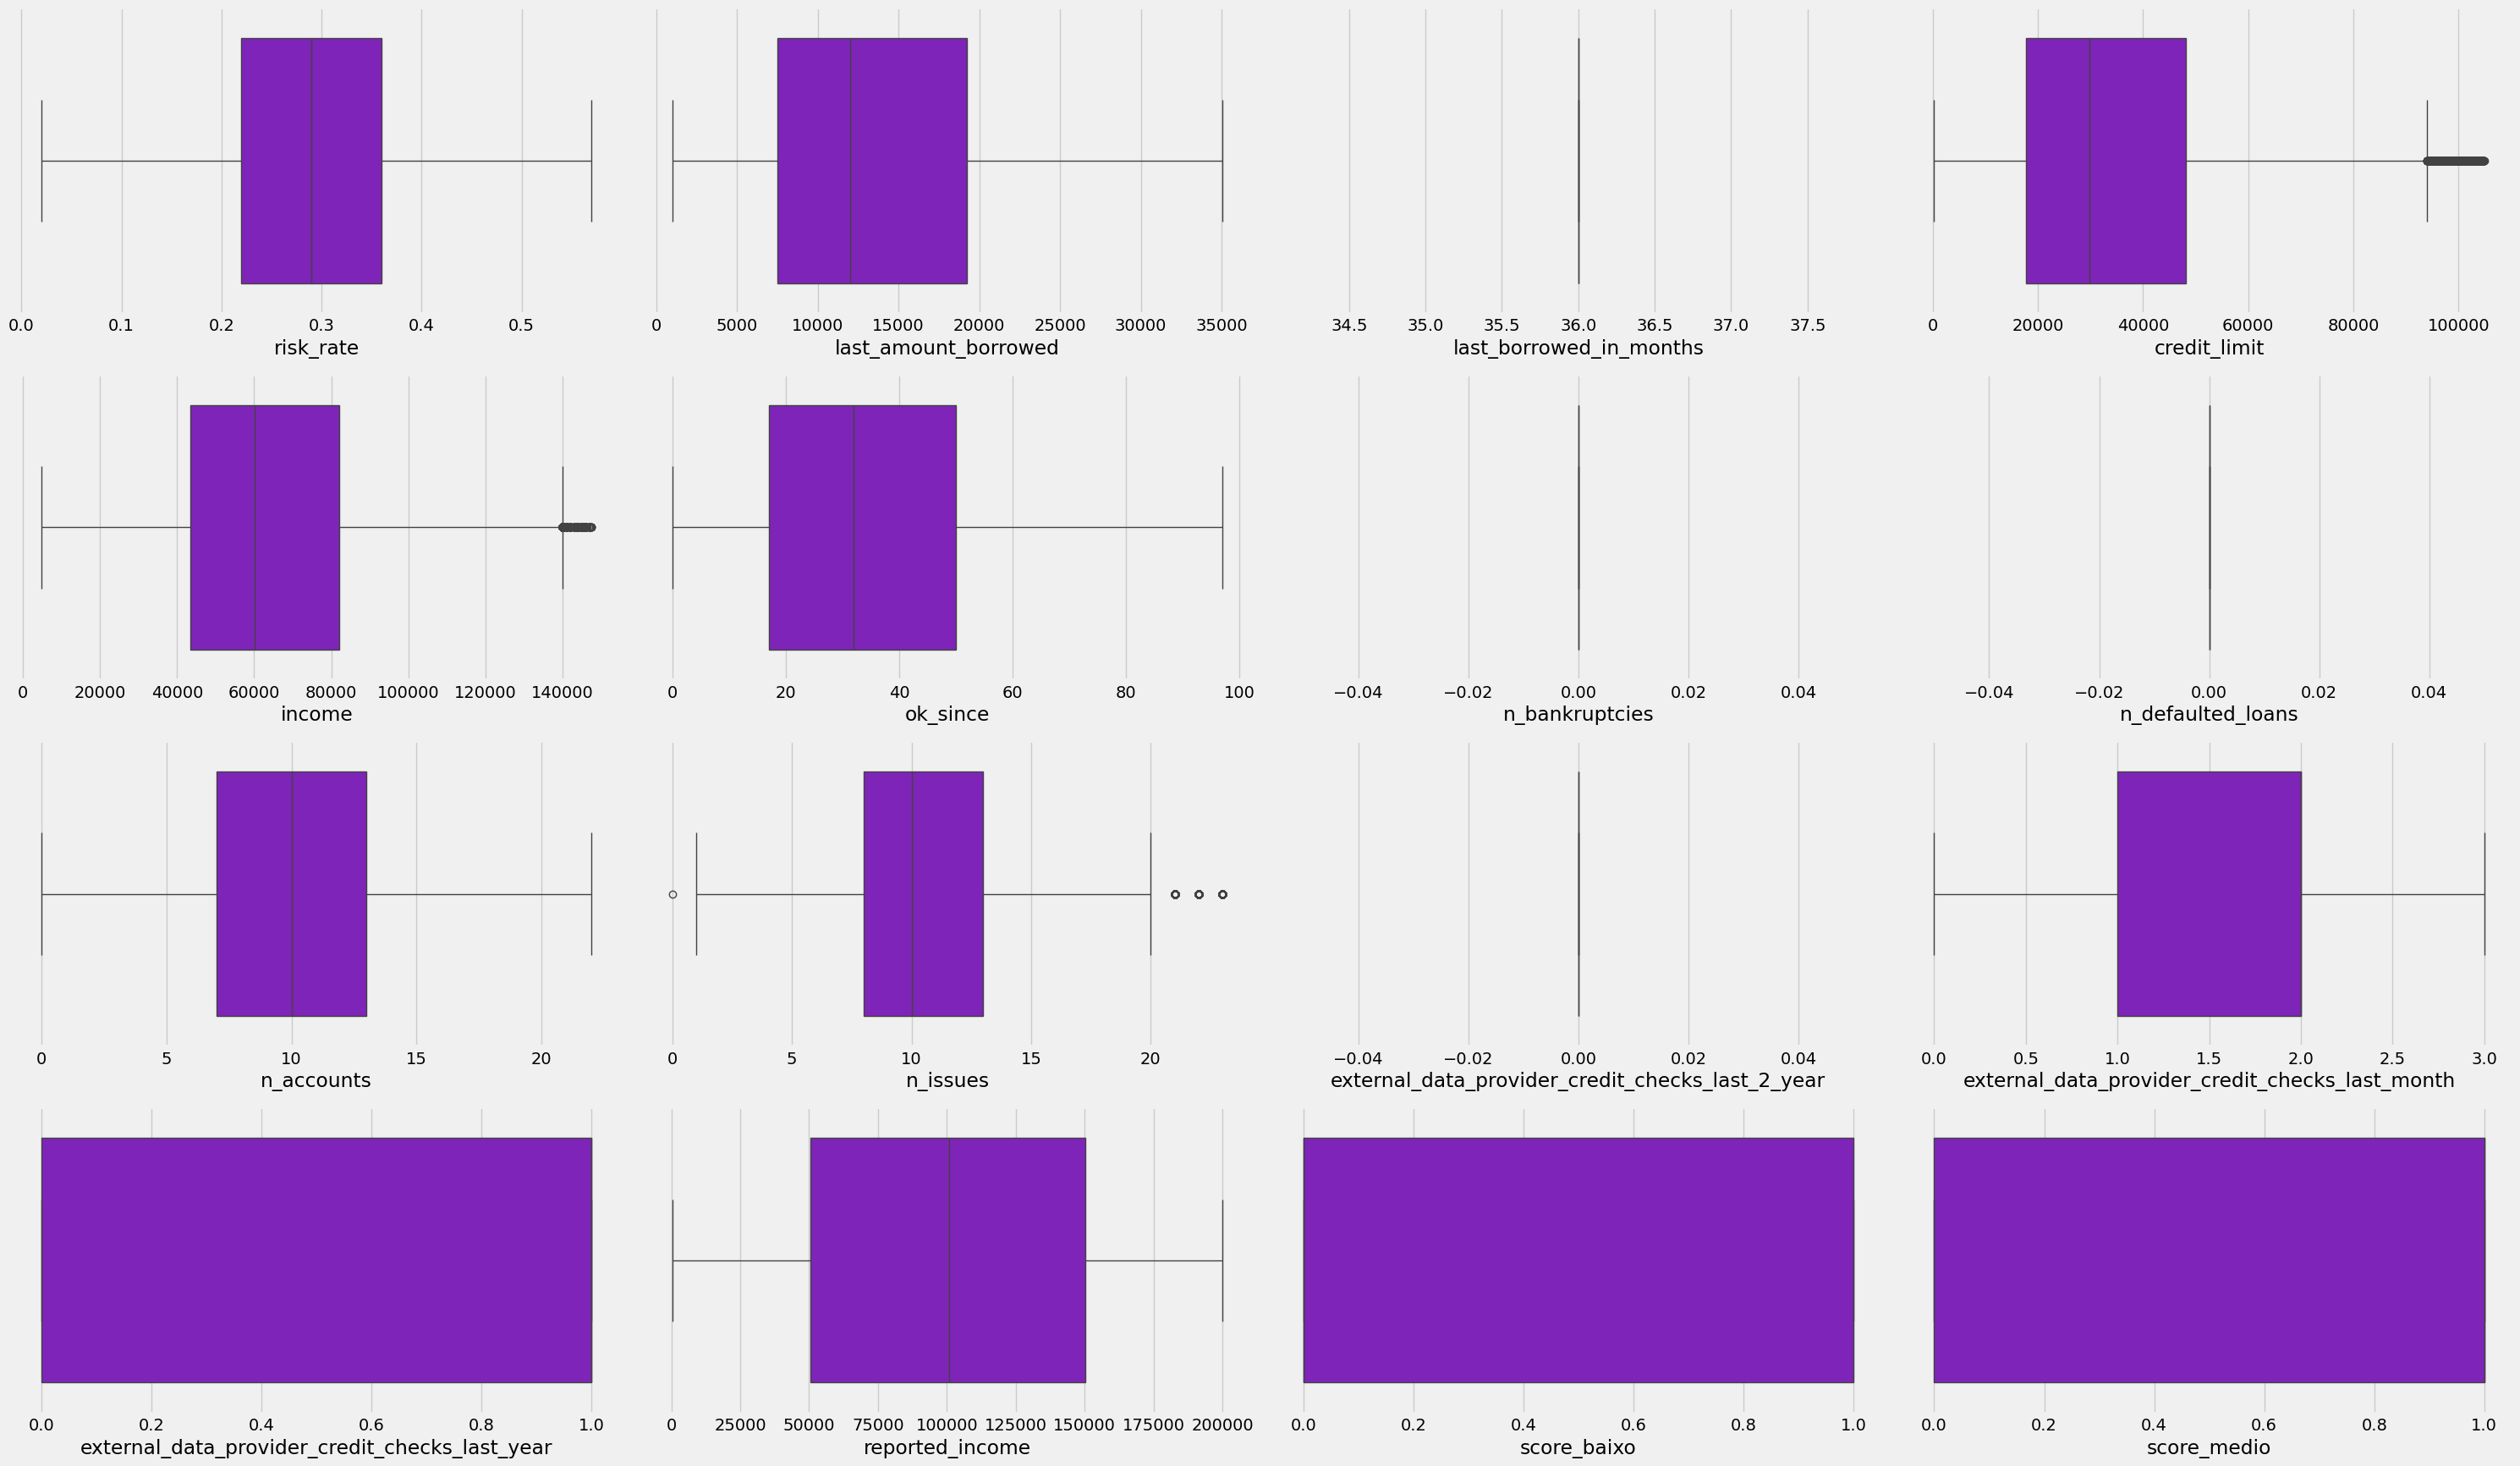

In [46]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(X):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=X,x=column, color="#830BD1")
    
plt.tight_layout(pad = 1.0)

### Train Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Pré-Processamento

- Preencher valores ausentes em X_train e X_test

In [48]:
# Preencher valores ausentes em X_train e X_test com a média de X_train
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # Usar a média de X_train para X_test

- Preencher valores ausentes em y_train e y_test

In [49]:
# Preencher valores ausentes em y_train e y_test com a mediana
y_train.fillna(y_train.median(), inplace=True)
y_test.fillna(y_train.median(), inplace=True)  # Usar a mediana de y_train para y_test


- Divisão das variáveis numéricas e categóricas

In [50]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
categorical_features = X_train.select_dtypes('object').columns.to_list()

- Número de linhas e colunas de cada treino e teste criados

In [51]:
print(f'Train shape: {X_train.shape}.')
print(f'Train target shape: {y_train.shape}.')
print(f'Test predictor shape: {X_test.shape}.')
print(f'Test target shape: {y_test.shape}.')

Train shape: (36000, 16).
Train target shape: (36000,).
Test predictor shape: (9000, 16).
Test target shape: (9000,).


### Estimação do Modelo Logístico Binário pela função "smf.glm"

A função **smf.glm** faz parte da biblioteca **statsmodels** em Python, que é amplamente utilizada para modelagem estatística. smf.glm é usada para ajustar **modelos lineares generalizados** (GLM, do inglês Generalized Linear Models).

O que são Modelos Lineares Generalizados (GLM)?

Os GLMs são uma extensão dos modelos lineares tradicionais que permitem modelar relações entre variáveis dependentes e independentes, mesmo quando a variável dependente não segue uma distribuição normal. Eles são úteis para situações em que:

- A variável dependente é binária (por exemplo, sucesso/falha).

- A variável dependente é contagem (por exemplo, número de eventos).

- A variável dependente segue outras distribuições, como Poisson, Binomial, Gamma, etc.

Quando usar smf.glm?

- Quando você precisa de flexibilidade para modelar diferentes tipos de variáveis dependentes.

- Quando os pressupostos de um modelo linear tradicional (como normalidade dos resíduos) não são atendidos.

- Para problemas de classificação, regressão de contagem, ou outros casos em que a variável dependente não é contínua.

Portanto o smf.glm é uma ferramenta poderosa para modelagem estatística em Python, especialmente quando se lida com dados que não seguem uma distribuição normal.

Na célula a seguir, foi feita uma concatenação de **X_train** e **y_train** para uma nova variável para que seja possível fazer a estimação.

In [52]:
train_smf_glm = pd.concat([X_train, y_train], axis=1)
train_smf_glm.reset_index(drop=True, inplace=True)
train_smf_glm.head()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_baixo,score_medio,target_default
0,0.17,"13,817.36",36.00,"32,451.00","95,035.02",34.96,0.00,0.00,7.00,7.00,0.00,0,0.00,"20,125.00",0.00,1.00,0.00
1,0.23,"13,817.36",36.00,"35,147.08","86,026.89",34.96,0.00,0.00,8.00,10.85,0.00,1,0.50,"24,460.00",0.00,1.00,0.00
2,0.40,"13,817.36",36.00,"35,147.08","45,042.92",34.96,0.00,0.00,3.00,10.85,0.00,2,1.00,"144,703.00",1.00,0.00,0.00
3,0.28,"13,817.36",36.00,"35,147.08","74,039.33",34.96,0.00,0.00,7.00,10.85,0.00,2,1.00,"186,114.00",1.00,0.00,0.00
4,0.22,"6,029.18",36.00,"35,147.08","55,026.98",34.96,0.00,0.00,9.00,10.85,0.00,0,0.50,"98,152.00",1.00,0.00,0.00


- Estimação do Modelo Logístico Binário 

In [53]:
model_train_smf_glm = smf.glm(
    formula='target_default ~ risk_rate + last_amount_borrowed + last_borrowed_in_months + \
             credit_limit + income + ok_since + n_bankruptcies + n_defaulted_loans + n_accounts + \
             n_issues + external_data_provider_credit_checks_last_2_year + external_data_provider_credit_checks_last_month + \
             external_data_provider_credit_checks_last_year + reported_income + score_baixo + score_medio',
    data=train_smf_glm,
    family=sm.families.Binomial()
).fit()

In [54]:
print(model_train_smf_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         target_default   No. Observations:                36000
Model:                            GLM   Df Residuals:                    35987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14904.
Date:                Wed, 29 Jan 2025   Deviance:                       29809.
Time:                        01:31:42   Pearson chi2:                 3.58e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01525
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### Pipeline

Implementamos aqui no Pipeline o StandardScaler().

O StandardScaler() é uma ferramenta do scikit-learn, usada para padronizar as características (features) de um conjunto de dados. A padronização é um processo comum em pré-processamento de dados, especialmente em algoritmos que são sensíveis à escala das features, como SVM, regressão linear, e redes neurais.

O que o StandardScaler() faz?

Ele transforma os dados de forma que a distribuição resultante tenha:

- Média zero: A média dos valores de cada feature é ajustada para 0.

- Variância unitária: A variância dos valores de cada feature é ajustada para 1.

Isso é feito subtraindo a média dos valores e dividindo pelo desvio padrão. Matematicamente, para cada valor 
$x$ de uma feature:

$$ z = \frac{x - \mu}{\sigma} $$

Onde:

$μ$ é a média da feature.

$σ$ é o desvio padrão da feature.

Quando usar o StandardScaler()?

- Quando os algoritmos de machine learning que você está usando são sensíveis à escala dos dados.

- Quando as features têm unidades diferentes (por exemplo, metros e quilogramas).

- Quando você deseja que todas as features contribuam igualmente para o modelo, evitando que features com valores maiores dominem o processo de aprendizado.


In [55]:
numerical_pipeline = Pipeline(
    steps=[
        ('std_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', numerical_pipeline, numerical_features)
    ], remainder="passthrough"
)

In [56]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)

### Função de avaliação para fornecer todas as métricas após o treinamento do modelo

In [57]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [58]:
models = {
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier()
}
model_list = []
r2_list =[]

models_val_scores = dict()
models_train_scores = dict()

n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for i in range(len(list(models))):
    model = list(models.values())[i]

    start_time = time.time()
    
    model.fit(X_train_prepared, y_train) 

    end_time = time.time()
    training_time = end_time - start_time


    y_train_pred = model.predict(X_train_prepared)
    y_test_pred = model.predict(X_test)
    
    y_train_pred = model.predict(X_train_prepared)
    train_score = roc_auc_score(y_train, y_train_pred)

    val_scores = cross_val_score(model, X_train_prepared, y_train, scoring='roc_auc', cv=stratified_kfold)
    avg_val_score = val_scores.mean()
    val_score_std = val_scores.std()

    models_val_scores[model] = avg_val_score
    models_train_scores[model] = train_score

    model_list.append(list(models.keys())[i])

    print(f'{model} results: ')
    print('-'*50)
    print(f'Training score: {train_score}')
    print(f'Average validation score: {avg_val_score}')
    print(f'Standard deviation: {val_score_std}')
    print(f'Training time: {round(training_time, 5)} seconds')
    print()


LogisticRegression() results: 
--------------------------------------------------
Training score: 0.5
Average validation score: 0.5944431985973047
Standard deviation: 0.005961697262976688
Training time: 0.02621 seconds

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) results: 
------------